Get data


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/ZPO_projekt/data_images2.zip -r /content

In [ ]:
!unzip /content/data_images2.zip

Check data

69503
(288, 288, 4)
1.0
0.0


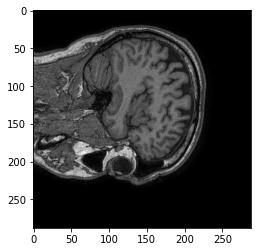

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

print(len(os.listdir('/content/content/Images/train/images/images')))

image = plt.imread('/content/content/Images/train/images/images/train_image_0_slice_112_.png')

print(image.shape)
print(image.max())
print(image.min())
plt.imshow(image)



In [ ]:
!rm -r /content/data_images2.zip

In [ ]:
import tensorflow as tf

augmentations=dict(
        horizontal_flip=True,
        vertical_flip=True
)

images_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255,
    # **augmentations,
    validation_split=0.2
    )

mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255,
    # **augmentations,
    validation_split=0.2
 )

In [ ]:
BATCH_SIZE = 128

train_images_generator = images_datagen.flow_from_directory(
    '/content/content/Images/train/images',
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    seed=42,
    interpolation='bilinear',
    color_mode='grayscale',
    class_mode=None,
    subset = 'training'
    )


train_mask_generator = mask_datagen.flow_from_directory(
    '/content/content/Images/train/masks',
     target_size=(128, 128),
     batch_size=BATCH_SIZE,
     seed=42,
     class_mode=None,
     color_mode='grayscale',
     interpolation='bilinear',
     subset = 'training'
    )

val_images_generator = images_datagen.flow_from_directory(
    '/content/content/Images/valid/images',
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    seed=42,
    interpolation='bilinear',
    color_mode='grayscale',
    class_mode=None,
    subset = 'validation'
    )


val_mask_generator = mask_datagen.flow_from_directory(
    '/content/content/Images/valid/masks',
     target_size=(128, 128),
     batch_size=BATCH_SIZE,
     interpolation ='bilinear',
     color_mode='grayscale',
     seed=42,
     class_mode=None,
     subset = 'validation'
    )

train_combined_generator = zip(train_images_generator, train_mask_generator)
val_combined_generator = zip(val_images_generator, val_mask_generator)

Found 55603 images belonging to 1 classes.
Found 55603 images belonging to 1 classes.
Found 1542 images belonging to 1 classes.
Found 1542 images belonging to 1 classes.


(128, 128, 1)
0.8313726
0.0
(128, 128)


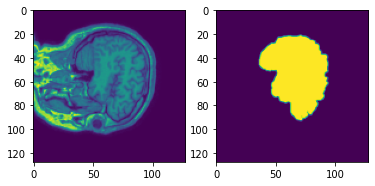

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

images,masks = next(train_combined_generator)
# print(images[0])

print(images[0].shape)
print(images[0].max())
print(images[0].min())
print(images[0].squeeze().shape)

fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(images[0].squeeze())
fig.add_subplot(1, 2, 2)
plt.imshow(masks[0].squeeze())

In [ ]:
!pip install segmentation_models

In [ ]:
%env SM_FRAMEWORK=tf.keras

In [ ]:

import segmentation_models
from segmentation_models import Unet
import keras
from segmentation_models.losses import dice_loss

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K



model_base = Unet('efficientnetb1', classes=1, activation='sigmoid', encoder_weights='imagenet', encoder_freeze=False)


input_ = Input(shape=(None, None, 1))
layer_1 = tf.keras.layers.Conv2D(3, (1, 1))(input_)
out = model_base(layer_1)
model = Model(input_, out, name="Model1")

optimizer = tf.keras.optimizers.Adam(lr=2e-4)

model.compile(optimizer=optimizer,
                   loss=dice_loss,
                   metrics=[segmentation_models.metrics.FScore(threshold=0.5)])

save_path = '/content/drive/MyDrive/ZPO_projekt/models/'

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_f1-score",
        patience=2,
        verbose=1,
        mode="max"
    ),
    keras.callbacks.ModelCheckpoint(
        monitor="val_f1-score",
        save_best_only=1,
        verbose=1,
        mode="max",
        filepath=save_path+"model_{epoch}"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_f1-score",
        factor=0.5,
        patience=2,
        mode="max"
    ),
    keras.callbacks.History()
]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint

BATCH_SIZE = 128
training_samples = train_images_generator.n
validation_samples = val_images_generator.n


history = model.fit(
    train_combined_generator, 
    steps_per_epoch=training_samples // BATCH_SIZE,
    validation_data = val_combined_generator,
    validation_steps = validation_samples // BATCH_SIZE,
    epochs=20,
    callbacks=callbacks,
    # workers=2,
    # use_multiprocessing=True,
    verbose=1
)
# model.save('/content/drive/MyDrive/ZPO_projekt/model_test_new_1.hdf5')

Epoch 1/20
 17/434 [>.............................] - ETA: 3:17:05 - loss: 0.7194 - f1-score: 0.4014

KeyboardInterrupt: ignored

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model binary accuracy')
plt.ylabel('binary accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


NameError: ignored

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
!cp /content/model_4 -r /content/drive/MyDrive/ZPO_projekt